# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [58]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [59]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [60]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
            return image, mask, merged_shape
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask

C:\Users\Alqia\AppData\Local\Temp\ipykernel_28884\1208373077.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))


<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

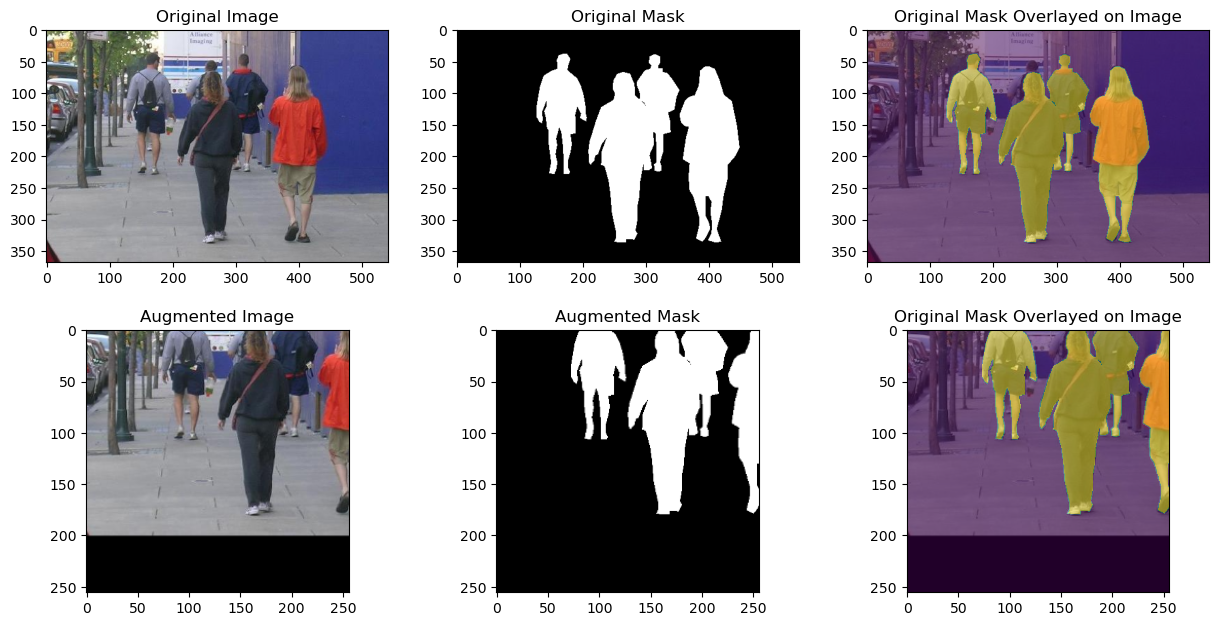

In [61]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze(), cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask.squeeze(), alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = 256

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size,scale=(0.35, 1.0), ratio=(1.0, 1.0))])
augmented_train_dataset = PennFudanDataset(
    train_image_paths, 
    train_mask_paths,
    transform=augmentation)
image, mask, _ = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze(),cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask.squeeze(), alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

test_dataset = PennFudanDataset(test_image_paths, test_mask_paths, image_size=image_size)

val_dataset = PennFudanDataset(val_image_paths, val_mask_paths, image_size=image_size)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [62]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [63]:
def dice_coefficient(output, ground_truth):
    numerical_stability = 1.
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, output, ground_truth):
        return 1 - dice_coefficient(output, ground_truth)

#### Training

[Table of Contents](#Table-of-Contents)

In [64]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, 
        filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask, _ in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = (model(image))
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask, _ in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = torch.round(model(image))
            loss = criterion(pred, mask)
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 1000
learning_rate=0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()#nn.BCELoss()#
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=25)

checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses = []
val_losses = []
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)

In [65]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while epoch < NUM_EPOCHS:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)

100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 1	Train Loss: 0.6667	Val Loss: 0.8855	Learning rate: 0.001
Checkpoint saved:	epoch = 1,	val loss = 0.8855


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 2	Train Loss: 0.5963	Val Loss: 0.7804	Learning rate: 0.001
Checkpoint saved:	epoch = 2,	val loss = 0.7804


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 3	Train Loss: 0.5749	Val Loss: 0.7348	Learning rate: 0.001
Checkpoint saved:	epoch = 3,	val loss = 0.7348


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 4	Train Loss: 0.5577	Val Loss: 0.5287	Learning rate: 0.001
Checkpoint saved:	epoch = 4,	val loss = 0.5287


100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


Epoch: 5	Train Loss: 0.5304	Val Loss: 0.5126	Learning rate: 0.001
Checkpoint saved:	epoch = 5,	val loss = 0.5126


100%|██████████| 17/17 [00:07<00:00,  2.13it/s]


Epoch: 6	Train Loss: 0.4960	Val Loss: 0.3752	Learning rate: 0.001
Checkpoint saved:	epoch = 6,	val loss = 0.3752


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 7	Train Loss: 0.4756	Val Loss: 0.3814	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


Epoch: 8	Train Loss: 0.4784	Val Loss: 0.5864	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 9	Train Loss: 0.4427	Val Loss: 0.4055	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 10	Train Loss: 0.4135	Val Loss: 0.4798	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


Epoch: 11	Train Loss: 0.4112	Val Loss: 0.5259	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


Epoch: 12	Train Loss: 0.3926	Val Loss: 0.3013	Learning rate: 0.001
Checkpoint saved:	epoch = 12,	val loss = 0.3013


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 13	Train Loss: 0.3788	Val Loss: 0.3364	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 14	Train Loss: 0.3738	Val Loss: 0.4621	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.46it/s]


Epoch: 15	Train Loss: 0.3845	Val Loss: 0.3929	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch: 16	Train Loss: 0.3615	Val Loss: 0.3295	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 17	Train Loss: 0.3519	Val Loss: 0.2946	Learning rate: 0.001
Checkpoint saved:	epoch = 17,	val loss = 0.2946


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 18	Train Loss: 0.3587	Val Loss: 0.5138	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.80it/s]


Epoch: 19	Train Loss: 0.3426	Val Loss: 0.2632	Learning rate: 0.001
Checkpoint saved:	epoch = 19,	val loss = 0.2632


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 20	Train Loss: 0.3253	Val Loss: 0.2620	Learning rate: 0.001
Checkpoint saved:	epoch = 20,	val loss = 0.2620


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 21	Train Loss: 0.3215	Val Loss: 0.2832	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 22	Train Loss: 0.3212	Val Loss: 0.3509	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch: 23	Train Loss: 0.3263	Val Loss: 0.3368	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 24	Train Loss: 0.3034	Val Loss: 0.3346	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


Epoch: 25	Train Loss: 0.3194	Val Loss: 0.2787	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 26	Train Loss: 0.3155	Val Loss: 0.2976	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


Epoch: 27	Train Loss: 0.2998	Val Loss: 0.2645	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 28	Train Loss: 0.2969	Val Loss: 0.3154	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 29	Train Loss: 0.3049	Val Loss: 0.3743	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 30	Train Loss: 0.2971	Val Loss: 0.2681	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 31	Train Loss: 0.2910	Val Loss: 0.2663	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 32	Train Loss: 0.2966	Val Loss: 0.3879	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 33	Train Loss: 0.2776	Val Loss: 0.2799	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 34	Train Loss: 0.2604	Val Loss: 0.2674	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.67it/s]


Epoch: 35	Train Loss: 0.2651	Val Loss: 0.2403	Learning rate: 0.001
Checkpoint saved:	epoch = 35,	val loss = 0.2403


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 36	Train Loss: 0.2732	Val Loss: 0.2413	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 37	Train Loss: 0.2675	Val Loss: 0.2981	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch: 38	Train Loss: 0.2599	Val Loss: 0.2298	Learning rate: 0.001
Checkpoint saved:	epoch = 38,	val loss = 0.2298


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 39	Train Loss: 0.2462	Val Loss: 0.2301	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


Epoch: 40	Train Loss: 0.2712	Val Loss: 0.2328	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 41	Train Loss: 0.2665	Val Loss: 0.2587	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 42	Train Loss: 0.2535	Val Loss: 0.2886	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.76it/s]


Epoch: 43	Train Loss: 0.2479	Val Loss: 0.2316	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.80it/s]


Epoch: 44	Train Loss: 0.2518	Val Loss: 0.2260	Learning rate: 0.001
Checkpoint saved:	epoch = 44,	val loss = 0.2260


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 45	Train Loss: 0.2336	Val Loss: 0.3208	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  4.09it/s]


Epoch: 46	Train Loss: 0.2334	Val Loss: 0.2283	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 47	Train Loss: 0.2294	Val Loss: 0.2510	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 48	Train Loss: 0.2432	Val Loss: 0.2549	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 49	Train Loss: 0.2403	Val Loss: 0.2199	Learning rate: 0.001
Checkpoint saved:	epoch = 49,	val loss = 0.2199


100%|██████████| 17/17 [00:04<00:00,  4.00it/s]


Epoch: 50	Train Loss: 0.2450	Val Loss: 0.2134	Learning rate: 0.001
Checkpoint saved:	epoch = 50,	val loss = 0.2134


In [66]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.3:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 50,	val loss = 0.2134


In [67]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.23:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 50,	val loss = 0.2134


In [68]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.2:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 50,	val loss = 0.2134


100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Epoch: 51	Train Loss: 0.2420	Val Loss: 0.2646	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 52	Train Loss: 0.2289	Val Loss: 0.2432	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 53	Train Loss: 0.2287	Val Loss: 0.2401	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 54	Train Loss: 0.2335	Val Loss: 0.2534	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.49it/s]


Epoch: 55	Train Loss: 0.2363	Val Loss: 0.3118	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 56	Train Loss: 0.2321	Val Loss: 0.2608	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 57	Train Loss: 0.2386	Val Loss: 0.2344	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 58	Train Loss: 0.2320	Val Loss: 0.2375	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 59	Train Loss: 0.2364	Val Loss: 0.2805	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.68it/s]


Epoch: 60	Train Loss: 0.2273	Val Loss: 0.2627	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 61	Train Loss: 0.2207	Val Loss: 0.2124	Learning rate: 0.001
Checkpoint saved:	epoch = 61,	val loss = 0.2124


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 62	Train Loss: 0.2285	Val Loss: 0.2495	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.83it/s]


Epoch: 63	Train Loss: 0.2277	Val Loss: 0.2469	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 64	Train Loss: 0.2211	Val Loss: 0.2173	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 65	Train Loss: 0.2164	Val Loss: 0.2118	Learning rate: 0.001
Checkpoint saved:	epoch = 65,	val loss = 0.2118


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 66	Train Loss: 0.2192	Val Loss: 0.2202	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch: 67	Train Loss: 0.2143	Val Loss: 0.2351	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 68	Train Loss: 0.2162	Val Loss: 0.2145	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 69	Train Loss: 0.2013	Val Loss: 0.2379	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 70	Train Loss: 0.2191	Val Loss: 0.2439	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  4.06it/s]


Epoch: 71	Train Loss: 0.2049	Val Loss: 0.2590	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 72	Train Loss: 0.2212	Val Loss: 0.2371	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 73	Train Loss: 0.2149	Val Loss: 0.2131	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 74	Train Loss: 0.2032	Val Loss: 0.1944	Learning rate: 0.001
Checkpoint saved:	epoch = 74,	val loss = 0.1944


In [69]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.15:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 74,	val loss = 0.1944


100%|██████████| 17/17 [00:04<00:00,  4.00it/s]


Epoch: 75	Train Loss: 0.2107	Val Loss: 0.2138	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 76	Train Loss: 0.1960	Val Loss: 0.2107	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 77	Train Loss: 0.2037	Val Loss: 0.2452	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 78	Train Loss: 0.1949	Val Loss: 0.1842	Learning rate: 0.001
Checkpoint saved:	epoch = 78,	val loss = 0.1842


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 79	Train Loss: 0.1840	Val Loss: 0.2199	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 80	Train Loss: 0.2093	Val Loss: 0.2384	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 81	Train Loss: 0.2157	Val Loss: 0.2102	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 82	Train Loss: 0.2039	Val Loss: 0.2032	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.92it/s]


Epoch: 83	Train Loss: 0.2076	Val Loss: 0.2176	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 84	Train Loss: 0.1953	Val Loss: 0.1935	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 85	Train Loss: 0.1950	Val Loss: 0.2158	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 86	Train Loss: 0.2021	Val Loss: 0.2217	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.99it/s]


Epoch: 87	Train Loss: 0.2013	Val Loss: 0.2027	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 88	Train Loss: 0.2037	Val Loss: 0.2394	Learning rate: 0.001


100%|██████████| 17/17 [00:03<00:00,  4.25it/s]


Epoch: 89	Train Loss: 0.2144	Val Loss: 0.2031	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]


Epoch: 90	Train Loss: 0.1987	Val Loss: 0.1913	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 91	Train Loss: 0.1960	Val Loss: 0.2025	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch: 92	Train Loss: 0.1927	Val Loss: 0.2179	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 93	Train Loss: 0.3179	Val Loss: 0.3441	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 94	Train Loss: 0.3271	Val Loss: 0.3093	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 95	Train Loss: 0.3544	Val Loss: 0.7061	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 96	Train Loss: 0.2987	Val Loss: 0.2988	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 97	Train Loss: 0.2894	Val Loss: 0.3060	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.72it/s]


Epoch: 98	Train Loss: 0.2600	Val Loss: 0.2602	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 99	Train Loss: 0.2627	Val Loss: 0.2371	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


Epoch: 100	Train Loss: 0.2556	Val Loss: 0.2133	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 101	Train Loss: 0.2420	Val Loss: 0.2472	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.80it/s]


Epoch: 102	Train Loss: 0.2251	Val Loss: 0.2268	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 103	Train Loss: 0.2432	Val Loss: 0.2215	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 104	Train Loss: 0.2215	Val Loss: 0.3839	Learning rate: 0.001
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 105	Train Loss: 0.2175	Val Loss: 0.1977	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.10it/s]


Epoch: 106	Train Loss: 0.1975	Val Loss: 0.1942	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 107	Train Loss: 0.2037	Val Loss: 0.1951	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 108	Train Loss: 0.2008	Val Loss: 0.1953	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 109	Train Loss: 0.2013	Val Loss: 0.1923	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.06it/s]


Epoch: 110	Train Loss: 0.1954	Val Loss: 0.1980	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 111	Train Loss: 0.1907	Val Loss: 0.1965	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 112	Train Loss: 0.1970	Val Loss: 0.1981	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 113	Train Loss: 0.1872	Val Loss: 0.2007	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.03it/s]


Epoch: 114	Train Loss: 0.1975	Val Loss: 0.1979	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 115	Train Loss: 0.1958	Val Loss: 0.1929	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Epoch: 116	Train Loss: 0.1958	Val Loss: 0.1986	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 117	Train Loss: 0.1880	Val Loss: 0.1936	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]


Epoch: 118	Train Loss: 0.2042	Val Loss: 0.2009	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.83it/s]


Epoch: 119	Train Loss: 0.1969	Val Loss: 0.1931	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 120	Train Loss: 0.1945	Val Loss: 0.1902	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch: 121	Train Loss: 0.1889	Val Loss: 0.1937	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 122	Train Loss: 0.1876	Val Loss: 0.1968	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 123	Train Loss: 0.1853	Val Loss: 0.1968	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 124	Train Loss: 0.1866	Val Loss: 0.1910	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.06it/s]


Epoch: 125	Train Loss: 0.1872	Val Loss: 0.1914	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 126	Train Loss: 0.1893	Val Loss: 0.1992	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.99it/s]


Epoch: 127	Train Loss: 0.1911	Val Loss: 0.1990	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 128	Train Loss: 0.1971	Val Loss: 0.1971	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.96it/s]


Epoch: 129	Train Loss: 0.1883	Val Loss: 0.1940	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch: 130	Train Loss: 0.1881	Val Loss: 0.1921	Learning rate: 0.0001
Epoch 00080: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 131	Train Loss: 0.1917	Val Loss: 0.1921	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 132	Train Loss: 0.1889	Val Loss: 0.1915	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.08it/s]


Epoch: 133	Train Loss: 0.1878	Val Loss: 0.1915	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.83it/s]


Epoch: 134	Train Loss: 0.1894	Val Loss: 0.1949	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 135	Train Loss: 0.1875	Val Loss: 0.1919	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]


Epoch: 136	Train Loss: 0.1816	Val Loss: 0.1926	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 137	Train Loss: 0.1977	Val Loss: 0.1919	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


Epoch: 138	Train Loss: 0.1849	Val Loss: 0.1929	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 139	Train Loss: 0.1829	Val Loss: 0.1919	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 140	Train Loss: 0.1838	Val Loss: 0.1927	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 141	Train Loss: 0.1866	Val Loss: 0.1925	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.21it/s]


Epoch: 142	Train Loss: 0.1885	Val Loss: 0.1912	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 143	Train Loss: 0.1780	Val Loss: 0.1916	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 144	Train Loss: 0.1794	Val Loss: 0.1914	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 145	Train Loss: 0.1923	Val Loss: 0.1919	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.82it/s]


Epoch: 146	Train Loss: 0.1893	Val Loss: 0.1925	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 147	Train Loss: 0.1828	Val Loss: 0.1924	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 148	Train Loss: 0.1785	Val Loss: 0.1940	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 149	Train Loss: 0.1894	Val Loss: 0.1914	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 150	Train Loss: 0.1828	Val Loss: 0.1938	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.05it/s]


Epoch: 151	Train Loss: 0.1911	Val Loss: 0.1923	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 152	Train Loss: 0.1836	Val Loss: 0.1926	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 153	Train Loss: 0.1856	Val Loss: 0.1912	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 154	Train Loss: 0.1875	Val Loss: 0.1934	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.14it/s]


Epoch: 155	Train Loss: 0.1884	Val Loss: 0.1905	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 156	Train Loss: 0.1971	Val Loss: 0.1912	Learning rate: 1e-05
Epoch 00106: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 157	Train Loss: 0.1855	Val Loss: 0.1917	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 158	Train Loss: 0.1826	Val Loss: 0.1920	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  4.12it/s]


Epoch: 159	Train Loss: 0.1795	Val Loss: 0.1913	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 160	Train Loss: 0.1847	Val Loss: 0.1917	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.87it/s]


Epoch: 161	Train Loss: 0.1804	Val Loss: 0.1934	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 162	Train Loss: 0.1779	Val Loss: 0.1923	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.99it/s]


Epoch: 163	Train Loss: 0.1861	Val Loss: 0.1924	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 164	Train Loss: 0.1919	Val Loss: 0.1928	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 165	Train Loss: 0.1822	Val Loss: 0.1932	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 166	Train Loss: 0.1795	Val Loss: 0.1929	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 167	Train Loss: 0.1798	Val Loss: 0.1913	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 168	Train Loss: 0.1827	Val Loss: 0.1926	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 169	Train Loss: 0.1880	Val Loss: 0.1929	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.59it/s]


Epoch: 170	Train Loss: 0.1843	Val Loss: 0.1915	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 171	Train Loss: 0.1784	Val Loss: 0.1918	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.73it/s]


Epoch: 172	Train Loss: 0.1831	Val Loss: 0.1923	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 173	Train Loss: 0.1846	Val Loss: 0.1919	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 174	Train Loss: 0.1869	Val Loss: 0.1918	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 175	Train Loss: 0.1784	Val Loss: 0.1919	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 176	Train Loss: 0.1781	Val Loss: 0.1923	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 177	Train Loss: 0.1819	Val Loss: 0.1938	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


Epoch: 178	Train Loss: 0.1835	Val Loss: 0.1929	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 179	Train Loss: 0.1861	Val Loss: 0.1936	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch: 180	Train Loss: 0.1864	Val Loss: 0.1932	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 181	Train Loss: 0.1921	Val Loss: 0.1917	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:03<00:00,  4.27it/s]


Epoch: 182	Train Loss: 0.1882	Val Loss: 0.1920	Learning rate: 1.0000000000000002e-06
Epoch 00132: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 183	Train Loss: 0.1849	Val Loss: 0.1941	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 184	Train Loss: 0.1779	Val Loss: 0.1916	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 185	Train Loss: 0.1837	Val Loss: 0.1927	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 186	Train Loss: 0.1863	Val Loss: 0.1920	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 187	Train Loss: 0.1779	Val Loss: 0.1931	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 188	Train Loss: 0.1775	Val Loss: 0.1933	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.02it/s]


Epoch: 189	Train Loss: 0.1829	Val Loss: 0.1943	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


Epoch: 190	Train Loss: 0.1831	Val Loss: 0.1930	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.24it/s]


Epoch: 191	Train Loss: 0.1805	Val Loss: 0.1912	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 192	Train Loss: 0.1933	Val Loss: 0.1916	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.18it/s]


Epoch: 193	Train Loss: 0.1891	Val Loss: 0.1923	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Epoch: 194	Train Loss: 0.1885	Val Loss: 0.1925	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 195	Train Loss: 0.1884	Val Loss: 0.1918	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.67it/s]


Epoch: 196	Train Loss: 0.1852	Val Loss: 0.1931	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 197	Train Loss: 0.1924	Val Loss: 0.1945	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.96it/s]


Epoch: 198	Train Loss: 0.1842	Val Loss: 0.1923	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 199	Train Loss: 0.1843	Val Loss: 0.1914	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.13it/s]


Epoch: 200	Train Loss: 0.1807	Val Loss: 0.1936	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 201	Train Loss: 0.1795	Val Loss: 0.1924	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 202	Train Loss: 0.1884	Val Loss: 0.1918	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 203	Train Loss: 0.1847	Val Loss: 0.1924	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.10it/s]


Epoch: 204	Train Loss: 0.1837	Val Loss: 0.1914	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.88it/s]


Epoch: 205	Train Loss: 0.1857	Val Loss: 0.1928	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 206	Train Loss: 0.1866	Val Loss: 0.1948	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 207	Train Loss: 0.1789	Val Loss: 0.1935	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 208	Train Loss: 0.1820	Val Loss: 0.1913	Learning rate: 1.0000000000000002e-07
Epoch 00158: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 17/17 [00:04<00:00,  3.99it/s]


Epoch: 209	Train Loss: 0.1848	Val Loss: 0.1940	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 210	Train Loss: 0.1868	Val Loss: 0.1926	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.94it/s]


Epoch: 211	Train Loss: 0.1833	Val Loss: 0.1920	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 212	Train Loss: 0.1831	Val Loss: 0.1931	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]


Epoch: 213	Train Loss: 0.1807	Val Loss: 0.1933	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 214	Train Loss: 0.1900	Val Loss: 0.1926	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 215	Train Loss: 0.1943	Val Loss: 0.1924	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 216	Train Loss: 0.1917	Val Loss: 0.1917	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 217	Train Loss: 0.1821	Val Loss: 0.1915	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 218	Train Loss: 0.1868	Val Loss: 0.1957	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 219	Train Loss: 0.1827	Val Loss: 0.1924	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:07<00:00,  2.42it/s]


Epoch: 220	Train Loss: 0.1852	Val Loss: 0.1932	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 221	Train Loss: 0.1790	Val Loss: 0.1922	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 222	Train Loss: 0.1890	Val Loss: 0.1915	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 223	Train Loss: 0.1855	Val Loss: 0.1947	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 224	Train Loss: 0.1953	Val Loss: 0.1927	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 225	Train Loss: 0.1883	Val Loss: 0.1913	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 226	Train Loss: 0.1803	Val Loss: 0.1930	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 227	Train Loss: 0.1839	Val Loss: 0.1921	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


KeyboardInterrupt: 

Checkpoint loaded:	start epoch = 228,	val loss = 0.1842


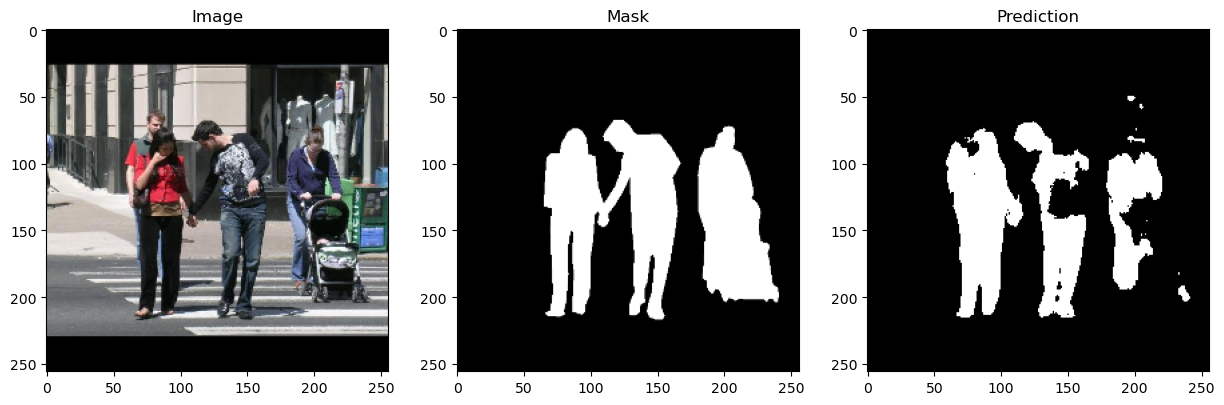

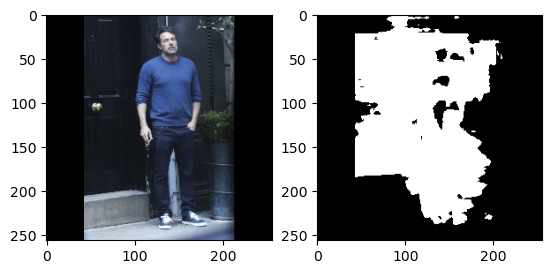

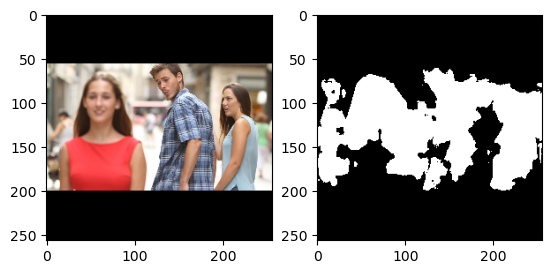

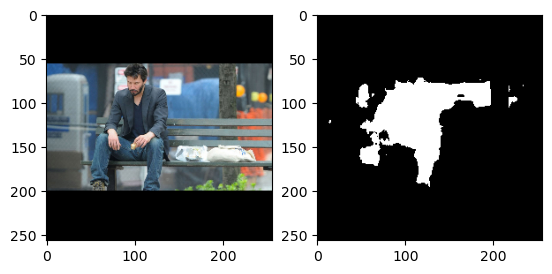

In [70]:
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask, _ = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = torch.round(model(image))
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[3].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[3].squeeze(), cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[3].squeeze(), cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()
    

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, shape = square_pad(image)
        image = cv2.resize(image, (image_size, image_size))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = torch.round(pred)
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [ ]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README1.md

[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 1891631 bytes to aaz7118-CA04.html
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README1_files\
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Writing 25114 bytes to README1.md
